<a href="https://colab.research.google.com/github/SibiShanmuga/Tumor-Detection-Algorithm/blob/main/brain_tumor_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Setup and Imports ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!pip install kaggle

from google.colab import files
files.upload()  # upload kaggle.json here

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip -d data


Streaming output truncated to the last 5000 lines.
  inflating: data/Training/glioma/Tr-gl_0712.jpg  
  inflating: data/Training/glioma/Tr-gl_0713.jpg  
  inflating: data/Training/glioma/Tr-gl_0714.jpg  
  inflating: data/Training/glioma/Tr-gl_0715.jpg  
  inflating: data/Training/glioma/Tr-gl_0716.jpg  
  inflating: data/Training/glioma/Tr-gl_0717.jpg  
  inflating: data/Training/glioma/Tr-gl_0718.jpg  
  inflating: data/Training/glioma/Tr-gl_0719.jpg  
  inflating: data/Training/glioma/Tr-gl_0720.jpg  
  inflating: data/Training/glioma/Tr-gl_0721.jpg  
  inflating: data/Training/glioma/Tr-gl_0722.jpg  
  inflating: data/Training/glioma/Tr-gl_0723.jpg  
  inflating: data/Training/glioma/Tr-gl_0724.jpg  
  inflating: data/Training/glioma/Tr-gl_0725.jpg  
  inflating: data/Training/glioma/Tr-gl_0726.jpg  
  inflating: data/Training/glioma/Tr-gl_0727.jpg  
  inflating: data/Training/glioma/Tr-gl_0728.jpg  
  inflating: data/Training/glioma/Tr-gl_0729.jpg  
  inflating: data/Training/glio

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Enhanced data generators with stronger augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,           # increased from 15
    width_shift_range=0.15,      # increased from 0.1
    height_shift_range=0.15,     # increased from 0.1
    zoom_range=0.2,              # increased from 0.1
    horizontal_flip=True,
    shear_range=0.15,            # added shear
    vertical_flip=False,         # medical images shouldn't flip vertically
    fill_mode='nearest',
    validation_split=0.2         # 20% for validation
)

# Test data generator - only rescaling, no augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/data/Training'

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


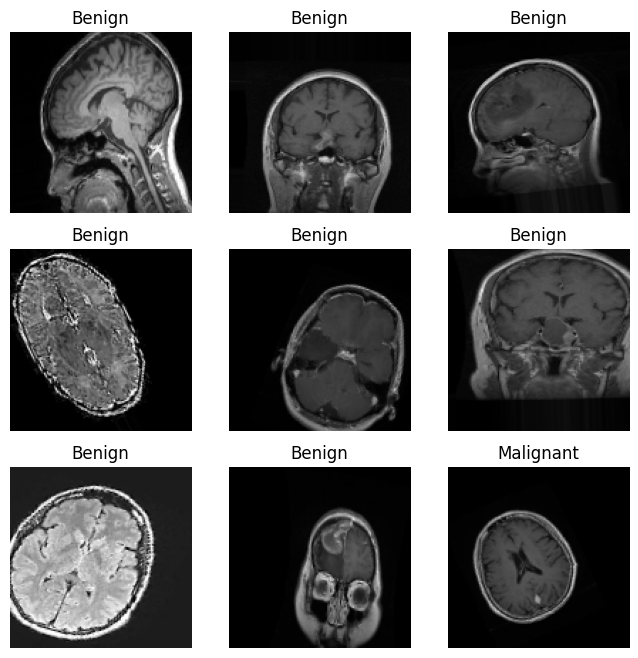

In [ ]:
# --- Visualize sample images correctly ---
images, labels = next(train_gen)  # Get one batch of images and labels

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title("Malignant" if labels[i] == 1 else "Benign")
    plt.axis("off")
plt.show()



Training the dataset with the loaded data

In [ ]:
# --- Optimized CNN Model Definition with Batch Normalization ---
from tensorflow.keras.regularizers import l2

model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    # Block 4 - Additional depth
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # output layer for binary classification
])

# Compile with optimized settings
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 124, 124, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 58, 58, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,258,209 (8.61 MB)

 Trainable params: 2,256,033 (8.61 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [ ]:
# --- Model Training with Advanced Callbacks ---
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Calculate class weights to handle potential class imbalance
samples_per_class = train_gen.samples / len(train_gen.class_indices)
class_weight = {0: 1.0, 1: 1.0}  # adjust if you detect imbalance

# Callbacks for improved training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_brain_tumor_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train with more epochs - early stopping will prevent overfitting
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,  # increased from 10 - early stopping will limit overfitting
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weight
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.2918 - loss: -0.2228
Epoch 1: val_accuracy improved from -inf to 0.29010, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 62s 299ms/step - accuracy: 0.2918 - loss: -0.2418 - val_accuracy: 0.2901 - val_loss: -28.2463 - learning_rate: 0.0010
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.2962 - loss: -15.3455
Epoch 2: val_accuracy improved from 0.29010 to 0.29185, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.2962 - loss: -15.3853 - val_accuracy: 0.2918 - val_loss: 68.6955 - learning_rate: 0.0010
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.2912 - loss: -43.9263
Epoch 3: val_accuracy did not improve from 0.29185
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 190ms/step - accuracy: 0.2912 - loss: -44.0038 - val_accuracy: 0.2848 - val_loss: 84.2561 - learning_rate: 0.0010
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.2894 - loss: -93.1499
Epoch 4: val_accuracy did not improve from 0.29185
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - accuracy: 0.2894 - loss: -93.2377 - val_accuracy: 0.2524 - val_loss: -46.8782 - learning_rate: 0.0010
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.2955 - loss: -159.2950
Epoch 5: val_accuracy improved from 0.29185 to 0.32515, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 190ms/step - accuracy: 0.2955 - loss: -159.4261 - val_accuracy: 0.3252 - val_loss: -114.6130 - learning_rate: 0.0010
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.2987 - loss: -243.1689
Epoch 6: val_accuracy did not improve from 0.32515
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 188ms/step - accuracy: 0.2987 - loss: -243.3078 - val_accuracy: 0.2393 - val_loss: -365.0111 - learning_rate: 0.0010
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3167 - loss: -337.8879
Epoch 7: val_accuracy did not improve from 0.32515
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - accuracy: 0.3167 - loss: -338.1219 - val_accuracy: 0.2296 - val_loss: -499.2892 - learning_rate: 0.0010
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3032 - loss: -449.9437
Epoch 8: val_accuracy did not improve from 0.32515
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 190ms/step - accuracy: 0.3032 - loss: -450.2105 - val_accuracy: 0.2603 - val_loss: -576.170

143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - accuracy: 0.3072 - loss: -728.9675 - val_accuracy: 0.3567 - val_loss: -789.3870 - learning_rate: 0.0010
Epoch 11/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3285 - loss: -890.7482
Epoch 11: val_accuracy did not improve from 0.35670
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 190ms/step - accuracy: 0.3284 - loss: -891.1262 - val_accuracy: 0.3322 - val_loss: -1028.6198 - learning_rate: 0.0010
Epoch 12/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3080 - loss: -1079.6448
Epoch 12: val_accuracy did not improve from 0.35670
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 190ms/step - accuracy: 0.3079 - loss: -1079.9603 - val_accuracy: 0.3129 - val_loss: -1420.5112 - learning_rate: 0.0010
Epoch 13/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3088 - loss: -1265.6113
Epoch 13: val_accuracy did not improve from 0.35670
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 190ms/step - accuracy: 0.3088 - loss: -1265.9185 - val_accuracy: 0.3216 - val_lo

143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 190ms/step - accuracy: 0.3104 - loss: -1672.8256 - val_accuracy: 0.3611 - val_loss: -1926.3517 - learning_rate: 0.0010
Epoch 16/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3176 - loss: -1894.4744
Epoch 16: val_accuracy did not improve from 0.36109
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 188ms/step - accuracy: 0.3176 - loss: -1894.8247 - val_accuracy: 0.3567 - val_loss: -2046.1174 - learning_rate: 0.0010
Epoch 17/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3246 - loss: -2132.7202
Epoch 17: val_accuracy did not improve from 0.36109
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 190ms/step - accuracy: 0.3246 - loss: -2133.0010 - val_accuracy: 0.3006 - val_loss: -2148.6033 - learning_rate: 0.0010
Epoch 18/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.3133 - loss: -2374.8992
Epoch 18: val_accuracy improved from 0.36109 to 0.36196, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.3133 - loss: -2375.3279 - val_accuracy: 0.3620 - val_loss: -2848.2297 - learning_rate: 0.0010
Epoch 19/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3355 - loss: -2628.3137
Epoch 19: val_accuracy did not improve from 0.36196
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - accuracy: 0.3355 - loss: -2628.8386 - val_accuracy: 0.3287 - val_loss: -1208.0999 - learning_rate: 0.0010
Epoch 20/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3221 - loss: -2910.3354
Epoch 20: val_accuracy did not improve from 0.36196
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 188ms/step - accuracy: 0.3221 - loss: -2910.7571 - val_accuracy: 0.3593 - val_loss: -2646.1047 - learning_rate: 0.0010
Epoch 21/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.3144 - loss: -3193.1160
Epoch 21: val_accuracy did not improve from 0.36196
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 188ms/step - accuracy: 0.3145 - loss: -3193.4673 - val_accuracy: 0.3550 - va

143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - accuracy: 0.3271 - loss: -3378.1277 - val_accuracy: 0.3699 - val_loss: -3617.2104 - learning_rate: 0.0010
Epoch 23/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3259 - loss: -3786.1060
Epoch 23: val_accuracy did not improve from 0.36985
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 188ms/step - accuracy: 0.3259 - loss: -3786.3677 - val_accuracy: 0.2989 - val_loss: -1351.1823 - learning_rate: 0.0010
Epoch 24/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3383 - loss: -4111.8267
Epoch 24: val_accuracy did not improve from 0.36985
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 190ms/step - accuracy: 0.3383 - loss: -4112.1348 - val_accuracy: 0.3663 - val_loss: -2595.5076 - learning_rate: 0.0010
Epoch 25/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3352 - loss: -4457.6226
Epoch 25: val_accuracy did not improve from 0.36985
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - accuracy: 0.3352 - loss: -4457.7446 - val_accuracy: 0.3541 - va

143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 190ms/step - accuracy: 0.3238 - loss: -5815.4287 - val_accuracy: 0.3900 - val_loss: -6132.4287 - learning_rate: 0.0010
Epoch 30/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3255 - loss: -6082.1426
Epoch 30: val_accuracy did not improve from 0.39001
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - accuracy: 0.3255 - loss: -6082.8159 - val_accuracy: 0.3427 - val_loss: -5487.9668 - learning_rate: 0.0010
Epoch 31/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3461 - loss: -6350.4185
Epoch 31: val_accuracy did not improve from 0.39001
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 188ms/step - accuracy: 0.3461 - loss: -6351.6069 - val_accuracy: 0.3795 - val_loss: -6981.7695 - learning_rate: 0.0010
Epoch 32/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.3190 - loss: -6946.8535
Epoch 32: val_accuracy did not improve from 0.39001
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 188ms/step - accuracy: 0.3191 - loss: -6946.9395 - val_accuracy: 0.3734 - va

143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 190ms/step - accuracy: 0.3248 - loss: -7572.0200 - val_accuracy: 0.3935 - val_loss: -5350.2544 - learning_rate: 0.0010
Epoch 35/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3417 - loss: -8103.5625
Epoch 35: val_accuracy did not improve from 0.39351
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 190ms/step - accuracy: 0.3417 - loss: -8104.0142 - val_accuracy: 0.3593 - val_loss: -8235.1133 - learning_rate: 0.0010
Epoch 36/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3411 - loss: -8421.1260
Epoch 36: val_accuracy improved from 0.39351 to 0.40403, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step - accuracy: 0.3411 - loss: -8422.3760 - val_accuracy: 0.4040 - val_loss: -8859.2178 - learning_rate: 0.0010
Epoch 37/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3423 - loss: -8881.0449
Epoch 37: val_accuracy did not improve from 0.40403
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - accuracy: 0.3422 - loss: -8881.9990 - val_accuracy: 0.3567 - val_loss: -8948.3125 - learning_rate: 0.0010
Epoch 38/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3212 - loss: -9357.3223
Epoch 38: val_accuracy did not improve from 0.40403
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 190ms/step - accuracy: 0.3212 - loss: -9357.4648 - val_accuracy: 0.3979 - val_loss: -8904.6680 - learning_rate: 0.0010
Epoch 39/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3328 - loss: -9967.7734
Epoch 39: val_accuracy did not improve from 0.40403
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - accuracy: 0.3329 - loss: -9967.1064 - val_accuracy: 0.3970 - va

143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - accuracy: 0.3332 - loss: -15125.8066 - val_accuracy: 0.4058 - val_loss: -9396.6543 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 49.


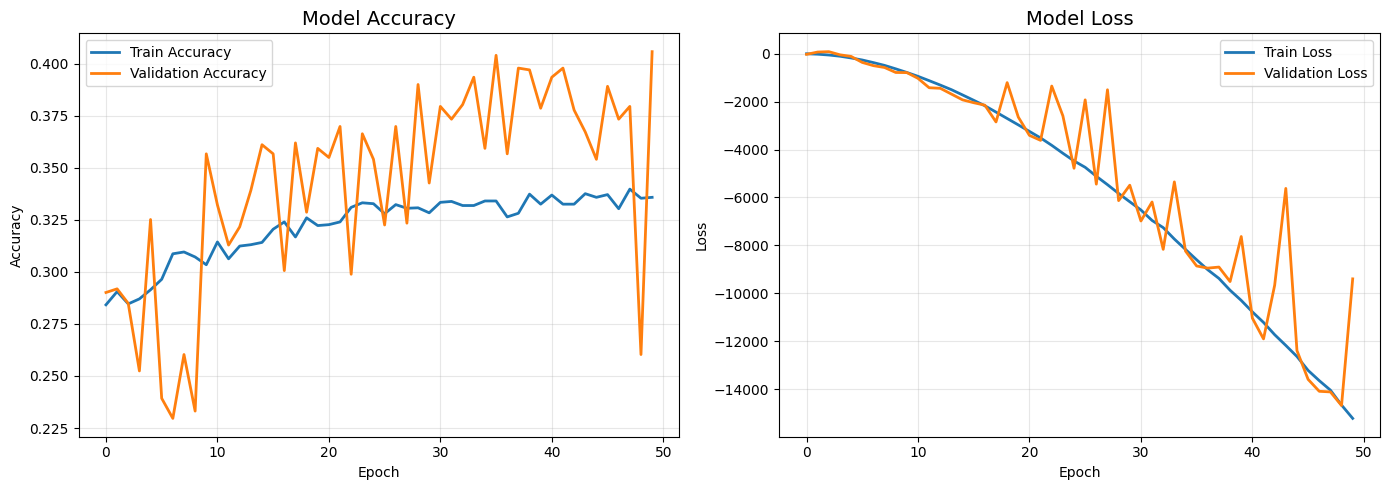


Training Summary:
Final Train Accuracy: 0.3358
Final Validation Accuracy: 0.4058
Best Validation Accuracy: 0.4058
Total Epochs Trained: 50


In [ ]:
# --- Plot Training Results with Detailed Analysis ---
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print(f"\nTraining Summary:")
print(f"Final Train Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Total Epochs Trained: {len(history.history['accuracy'])}")

In [ ]:
# --- Save Models and Evaluation ---
# Save the final trained model
model.save('brain_tumor_cnn_model_final.h5')
print("Final model saved as 'brain_tumor_cnn_model_final.h5'")

# The best model is already saved by ModelCheckpoint callback
print("Best model saved as 'best_brain_tumor_model.h5' (highest validation accuracy)")

# Load and evaluate the best model
from tensorflow.keras.models import load_model
best_model = load_model('best_brain_tumor_model.h5')

print("\n--- Best Model Performance ---")
eval_results = best_model.evaluate(val_gen)
print(f"Validation Accuracy: {eval_results[1]:.4f}")
print(f"Validation Loss: {eval_results[0]:.4f}")

Final model saved as 'brain_tumor_cnn_model_final.h5'
Best model saved as 'best_brain_tumor_model.h5' (highest validation accuracy)



--- Best Model Performance ---
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.4283 - loss: -8968.0049
Validation Accuracy: 0.4040
Validation Loss: -9277.8242
